In [485]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register
import random as rd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from collections import deque

In [486]:
env = gym.make('CartPole-v1', render_mode = 'rgb_array')

In [487]:
env.action_space.n, env.observation_space.shape[0]

(2, 4)

In [488]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [489]:
class DQN(nn.Module):
    def __init__(self, lr):
        super(DQN, self).__init__()
        
        self.lr = lr
        self.memory = []
        self.fc1 = nn.Linear(env.observation_space.shape[0],64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,env.action_space.n)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)
    
class memory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen = capacity)
    
    def push(self, arr):
        self.memory.append(arr)

    def get_mini_batch(self, batch_size):
        return rd.sample(self.memory,batch_size)
    def __len__(self):
        return len(self.memory)
    
def get_action(obs, eps, model: DQN):
    with torch.no_grad():
        model.eval()
        Qs = model(torch.tensor(obs).to(device))
        if np.random.random() > eps:
            action = np.argmax(Qs.cpu().detach().numpy())
        else:
            action = np.random.randint(0,env.action_space.n)
    return action

def optimization(target_model, policy_model, memory, batch_size):
    global d_factor
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(policy_model.parameters(), lr = policy_model.lr)

    if len(memory) < batch_size:
        return
    else:
        batch = memory.get_mini_batch(batch_size)
    
    # print((d_factor * target_model(torch.stack([batch[i][2] for i in range(batch_size)]).to(device))).size())
    y_hat = policy_model(torch.stack([batch[i][0] for i in range(batch_size)]).to(device)).max(1)[0]
    with torch.no_grad():
        y = d_factor * target_model(torch.stack([batch[i][2] for i in range(batch_size)]).to(device)).max(1)[0] + torch.stack([batch[i][3] for i in range(batch_size)]).to(device)
    
    cost = criterion(y.to(device), y_hat.to(device))
    cost.backward()
    optimizer.step()



https://tutorials.pytorch.kr/intermediate/reinforcement_q_learning.html

In [490]:
batch_size = 128
gamma = 0.99
epochs = 50000
d_factor = 0.95
eps_decay = 0.99995
eps = 1
lr = 0.1
train_start_epoch = 10000

In [491]:
policy_model = DQN(lr = 0.001).to(device)
target_model = DQN(lr = 0.001).to(device)
target_model.load_state_dict(policy_model.state_dict())

<All keys matched successfully>

In [492]:
timelist = [0]
epslist = []
memory = memory(10000)

for epoch in range(epochs):
    
    observation = env.reset()[0]
    done = False
    time = 0
    
    while not done:
        time += 1
        action = get_action(observation, eps, policy_model)
        new_observation, reward, done, _, _ =  env.step(action)
        memory.push(tuple(map(torch.tensor,(observation, action, new_observation, reward))))
        observation = new_observation
    
    optimization(target_model, policy_model, memory, batch_size)
    
    if timelist[-1] > time and epoch > 5000:
        eps = math.pow(eps_decay, epoch - 5000)
    timelist.append(time)
    epslist.append(eps)
    if (epoch+1) % 1000 == 0:
        print(epoch, time) 

999 33
1999 15
2999 21
3999 14
4999 16
5999 23
6999 15
7999 14
8999 25
9999 22
10999 22
11999 12
12999 30
13999 14
14999 16
15999 13
16999 12
17999 12
18999 12


In [ ]:
model = DQN(lr = 0.001).to(device)
target_model = DQN(lr = 0.001).to(device)

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = model.lr)
timelist = [0]
epslist = []

for epoch in range(epochs):
    
    observation = env.reset()[0]
    done = False
    time = 0
    
    while not done:
        time += 1
        Qs = model(torch.tensor(observation).to(device))
        if np.random.random() > eps:
            action = np.argmax(Qs.cpu().detach().numpy())
        else:
            action = np.random.randint(0,env.action_space.n)
        new_observation, reward, done, _, _ =  env.step(action)
        Qnext = model(torch.tensor(new_observation).to(device))
        
        if done:
            y_hat = -100
        else:
            y_hat = reward + d_factor * np.argmax(Qnext.cpu().detach().numpy())
        # print(observation,  y)
        # print(Qs.type(),  torch.tensor(y).type())
        cost = criterion(Qs, torch.tensor(y_hat).to(device).float())
        cost.backward()
        optimizer.step()
        observation = new_observation
    
    if timelist[-1] > time and epoch > 5000:
        eps = math.pow(eps_decay, epoch - 5000)
    timelist.append(time)
    epslist.append(eps)
    if (epoch+1) % 1000 == 0:
        print(epoch, time) 

c:\Users\dkstn\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


999 15


KeyboardInterrupt: 

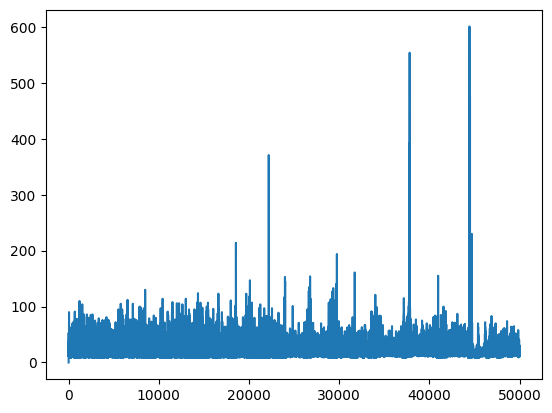

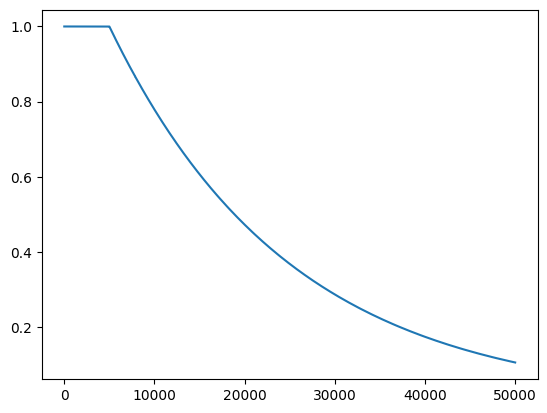

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(timelist)),timelist)
plt.show()
plt.plot(range(len(epslist)),epslist)